Sentiment analysis on movies reviews 
===

This weekly project is to perform sentimental analysis on movies reviews. The labeled dataset consists of 50,000 IMDB movie reviews, specially selected for sentiment analysis. The sentiment of reviews is binary, meaning the IMDB rating < 5 results in a sentiment score of 0, and rating >=7 have a sentiment score of 1. No individual movie has more than 30 reviews. The 25,000 reviews labeled training set does not include any of the same movies as the 25,000 review test set.

![Img](https://static.techprincess.it/wp-content/uploads/sites/5/2019/01/Imdb-freedive-1280x700-780x405.jpg)

### Understanding the dataset

- **Sentiment**: 0 - non-sentimental, 1 - sentimental
- **Review**: IMDB movie reviews
- **Id**: The id of the review

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Show plot in the notebook
%matplotlib inline

## 1. Load the dataset and check information

In [2]:
# Load the dataset 
data = pd.read_csv("./data/movie_review.csv", sep='\t')

In [40]:
test = pd.read_csv("./data/movie_review_noLabel.csv", sep='\t')

In [3]:
# Check some random observations 
data[data['sentiment']==1].sample(5)

,id,review,sentiment
10325,8268_7,This is apparently the second remake of this f...,1


In [41]:
test.head()

,id,review
0,10633_1,I watched this video at a friend's house. I'm ...
1,4489_1,`The Matrix' was an exciting summer blockbuste...
2,3304_10,This movie is one among the very few Indian mo...
3,3350_3,The script for this movie was probably found i...
4,1119_1,Even if this film was allegedly a joke in resp...


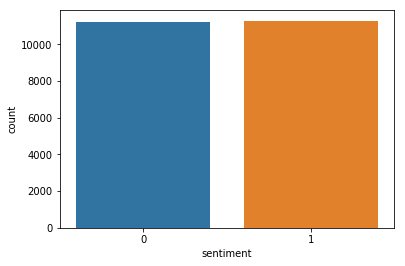

In [5]:
sns.countplot(data['sentiment'])

## 2. Data clean up
### a. Removing stop words

In [5]:
import nltk
# import the library for stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to C:\Users\Hang
[nltk_data]     Nguyen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from collections import Counter
vocab = Counter()

# Let's apply the example above to count words in our SentimentText

for i in data['review']:
    i = i.strip(' ')
    words = i.split()
    for word in words:
        vocab[word] += 1

In [7]:
vocab_reduced = Counter()
# Go through all of the items of vocab using vocab.items() and pick only words that are not in 'stop' 
# and save them in vocab_reduced
for w,i in vocab.items():
    if w not in stop:
        vocab_reduced[w] = i

# Save 30 most common words in stop_word
# Check 30 most common words whether these words play an import role in sentimental analysis or not.
# If yes then delete it from the stop_word
stop_word = vocab_reduced.most_common(30)
del stop_word[28:]
del stop_word[25]
del stop_word[17] 
del stop_word[11]
del stop_word[9]
del stop_word[6]

In [8]:
# Append words in stop_word in to stop
for i in stop_word:
    stop.append(i[0])

In [9]:
# Since python is case-sensitive language 
# Append 
for i in stop:
    a = i.capitalize()
    if a not in stop:
        stop.append(a)

In [10]:
import re

In [11]:
def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Remove unneccessary mark
    text = re.sub('[\"]','',text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-word character and append the emoticons,
    # removing the nose character for standarization. Convert to lower case
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
    
    return text


In [12]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()

# write a function called `tokenizer()` that split a text into list of words
def tokenizer(text):
    token = [] 
    # Your code here
    token = text.split()
    return token


# write a function named `tokenizer_porter()` that split a text into list of words and apply stemming technic
# Hint: porter.stem(word)
def tokenizer_porter(text):
    token = []
    # Your code here
#     token = porter.stem(text)
    for word in tokenizer(text):
        a = porter.stem(word)
        if a not in token:
            token.append(a)
    return token


### b.Transform data 

In [13]:
# split the dataset in train and test
# Your code here
from sklearn.model_selection import train_test_split
X = data['review'] # LogisticRegression 1 feature
y = data['sentiment']

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words=stop,\
                        tokenizer=tokenizer_porter,\
                        preprocessor=preprocessor,\
                       ngram_range=(1,2))

In [60]:
X_tfidf = tfidf.fit_transform(X)

## Train / Test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,y,test_size=.3,random_state = 101)

## Build Model

In [14]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [18]:
# Initialize LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, SVC model
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svm = SVC(kernel='linear')

# Save all of those 4 models into models
models = [lr, dtc, rfc, svm]
models_name = ["Logistic Regression", "Decision Tree", "Random Forest", "SVM"]

In [20]:
# We create an utils function, that take a trained model as argument and print out confusion matrix
# classification report base on X and y
def evaluate_model(estimator, X, y):
    # Note: We should test on the original test set
    predictions = estimator.predict(X)
    acc = accuracy_score(predictions,y)
    cm = confusion_matrix(predictions,y)
    report = classification_report(predictions,y)
    vc = y.value_counts()
    print('Accuracy score:',acc)
    print('Confusion matrix:\n', cm)
    print('Classification report:\n', report)
    print('Testing set information:\n', vc)
    # Set print options
    np.set_printoptions(precision=2)
    return predictions, acc

In [22]:
# Now we will test on origin dataset (X_train_sub, y_train_sub)
# We loop for models
# For each model, we train with train_sub dataset
# and use evaluate_model function to test with test set
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    # Your code here
    model.fit(X_train,y_train)
    predictions, acc,cm,report = evaluate_model(model,X_test,y_test)
    print("=======================================")

Model: Logistic Regression
Accuracy score: 0.8865185185185185
Confusion matrix:
 [[2935  293]
 [ 473 3049]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      3228
           1       0.91      0.87      0.89      3522

   micro avg       0.89      0.89      0.89      6750
   macro avg       0.89      0.89      0.89      6750
weighted avg       0.89      0.89      0.89      6750

Testing set information:
 0    3408
1    3342
Name: sentiment, dtype: int64
Model: Decision Tree
Accuracy score: 0.7038518518518518
Confusion matrix:
 [[2424 1015]
 [ 984 2327]]
Classification report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.71      3439
           1       0.70      0.70      0.70      3311

   micro avg       0.70      0.70      0.70      6750
   macro avg       0.70      0.70      0.70      6750
weighted avg       0.70      0.70      0.70      6750

Testing set 

### Save model

In [29]:
import pickle
import os

In [32]:
pickle.dump(lr, open(os.path.join('data', 'logisticRegression.pkl'), 'wb'), protocol=4)

In [33]:
pickle.dump(svm, open(os.path.join('data', 'SVM.pkl'), 'wb'), protocol=4)

In [34]:
pickle.dump(dtc, open(os.path.join('data', 'DecisionTreeClassifier.pkl'), 'wb'), protocol=4)
pickle.dump(dtc, open(os.path.join('data', 'RandomForestClassifier.pkl'), 'wb'), protocol=4)

**As we can see that, LogisticRegression and SVC perform much more better than the other two. Eventhough, SVC has a higher accuracy score, LogisticRegression require much less time to train than SVC. As a result, we will go with LogisticRegression and try to improve the model of it.**

## Fine tune

### Random Forest Classifier

In [24]:
from sklearn.model_selection import cross_val_score

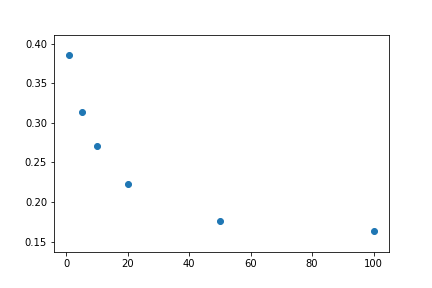

In [36]:
val_rate = []
n = [1 ,5 ,10, 20, 50, 100]

# Your code here
for i in n:
    clf = RandomForestClassifier(i)
    val_error = 1 - cross_val_score(clf, X_train, y_train,cv=5).mean()
    val_rate.append(val_error)
    print(i,val_error)

# Plot settings
plt.scatter(x = n, y = val_rate)
plt.show()

In [37]:
final_rfc = RandomForestClassifier(50)
final_rfc.fit(X_train,y_train)
final_rfc_predictions = final_rfc.predict(X_test)
accuracy_score(final_rfc_predictions,y_test)

0.8386666666666667

### Logistic Regression

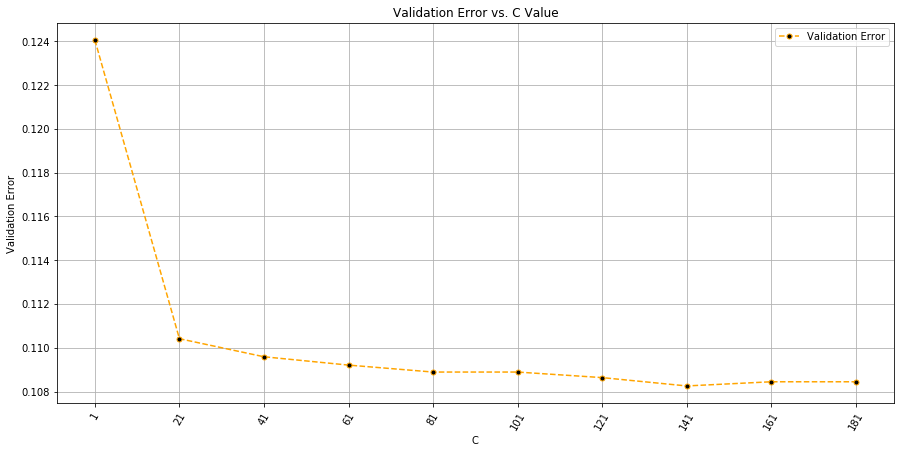

In [25]:
val_rate = []
c_range =  range(1,200,20)

# Your code here
for i in c_range:
    lr_2 = LogisticRegression(C=i)
    val_error = 1 - cross_val_score(lr_2, X_train, y_train,cv=5).mean()
    val_rate.append(val_error)

# Plot settings
plt.figure(figsize=(15,7))
plt.plot(c_range, val_rate, color='orange', linestyle='dashed', marker='o',
         markerfacecolor='black', markersize=5, label='Validation Error')

plt.xticks(np.arange(c_range.start, c_range.stop, c_range.step), rotation=60)
plt.grid()
plt.legend()
plt.title('Validation Error vs. C Value')
plt.xlabel('C')
plt.ylabel('Validation Error')
plt.show()

In [39]:
final_lr = LogisticRegression(C=141)
final_lr.fit(X_train,y_train)
final_lr_predictions = final_lr.predict(X_test)
accuracy_score(final_lr_predictions,y_test)

0.902074074074074

In [30]:
pickle.dump(final_lr, open(os.path.join('data', 'Final_logisticRegression.pkl'), 'wb'), protocol=4)

## Test model

In [ ]:
test = pd.read_csv("./data/movie_review_noLabel.csv", sep='\t')

In [50]:
test.head()

,id,review
0,10633_1,I watched this video at a friend's house. I'm ...
1,4489_1,`The Matrix' was an exciting summer blockbuste...
2,3304_10,This movie is one among the very few Indian mo...
3,3350_3,The script for this movie was probably found i...
4,1119_1,Even if this film was allegedly a joke in resp...


In [64]:
# transform test data
X_test_tfidf = tfidf.transform(test['review'])

In [62]:
test_predictions = final_lr.predict(X_test_tfidf)

In [63]:
test_predictions

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

In [66]:
test['sentiment'] = test_predictions

In [68]:
test.head()

,id,review,sentiment
0,10633_1,I watched this video at a friend's house. I'm ...,0
1,4489_1,`The Matrix' was an exciting summer blockbuste...,0
2,3304_10,This movie is one among the very few Indian mo...,1
3,3350_3,The script for this movie was probably found i...,0
4,1119_1,Even if this film was allegedly a joke in resp...,0


In [ ]:
test.to_csv('.\data\test.csv')